In [1]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)

from clipppy import load_config, Clipppy
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML
import pyro.distributions as dist

import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor
import torch.nn as nn
import time

import swyft

import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *


import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')

DEVICE = 'cuda'

In [2]:
SYSTEM_NAME = "ngc4414"
NSIM = 5000
SIM_PATH = f'store.zarr' 
N_SUB = 1

SIGMA = 0.1

### Utilities

In [3]:
def get_config(system_name: str) -> Clipppy:
    """
    Get configuration
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

    SOURCE_DIR = '../../mock_data/sources'
        
    source_name = f'{system_name}.npy'
    config = load_config('config-sub.yaml', base_dir=SOURCE_DIR)

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return config


def get_prior(config: Clipppy):
    """
    Set up subhalo parameter priors using a config
    """
    main = config.umodel.alphas["main"]
    prior_p_sub = main.sub.pos_sampler.base_dist
    lows = np.array(
        [
            prior_p_sub.low[0].item(),
            prior_p_sub.low[1].item(),
        ]
    )
    highs = np.array(
        [
            prior_p_sub.high[0].item(),
            prior_p_sub.high[1].item(),
        ]
    )
    vu = lambda u: (highs - lows) * u + lows
    return swyft.Prior(vu, 2), vu



def simul(v, config: Clipppy):
    """
    Fix values for main lens and source parameters from config and put
    in a subhalo with the specified position and mass.

    Arguments
    - v: array containing x_sub, y_sub.

    Returns
    - Numpy array.
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
    
    from pyrofit.lensing.utils import get_meshgrid  # import here due to HACKs
    nx = config.kwargs["defs"]["nx"]
    ny = config.kwargs["defs"]["ny"]
    res = config.kwargs["defs"]["res"]
    X, Y = config.umodel.X.clone(), config.umodel.Y.clone()
    # Upsample image
    upsample = 10
    config.umodel.coerce_XY(*get_meshgrid(res / upsample, nx * upsample, ny * upsample))
        
    x_sub, y_sub = np.squeeze(v.T)
    d_p_sub = dist.Delta(torch.tensor([x_sub, y_sub])).to_event(1)

    def _guide():
        # Sample subhalo position
        guide_sample = {
            "main/sub/p_sub": pyro.sample("main/sub/p_sub", d_p_sub),
        }

        return guide_sample
    
    result = {
        "image": CONFIG.ppd(guide=_guide)["model_trace"]
        .nodes["mu"]["value"]
        .detach()
        .numpy()
    }
    
    # Restore coarse grid
    config.umodel.coerce_XY(X, Y)
    # Downsample image
    averager = torch.nn.AvgPool2d((upsample, upsample))
    result['image'] = (averager(torch.tensor(result['image']).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0))

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return result

def noise(obs, _=None, sigma_n=SIGMA):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}

### Check utilities

In [4]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
CONFIG = get_config(SYSTEM_NAME)
torch.set_default_tensor_type(torch.FloatTensor)

In [5]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
ppd = CONFIG.ppd()['model_trace'].nodes
torch.set_default_tensor_type(torch.FloatTensor)

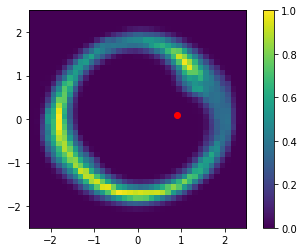

In [6]:
v = torch.tensor([0.9, 0.1])
plt.imshow(simul(v, CONFIG)['image'], **imkwargs)
plt.scatter(*v.t(), c="r")
plt.colorbar()

### Simulate

In [7]:
prior, vu = get_prior(CONFIG)
nx = CONFIG.kwargs["defs"]["nx"]
ny = CONFIG.kwargs["defs"]["ny"]

In [8]:
simulator = swyft.Simulator(model = lambda v: simul(v, CONFIG), 
                            pnames = ["x_sub", "y_sub"],
                            sim_shapes={"image": (nx, ny)})

# store = swyft.DirectoryStore(path=SIM_PATH, simulator=simulator)
store = swyft.MemoryStore(simulator)

store.add(NSIM, prior)
store.simulate()

Creating new store.
Store: Adding 4968 new samples to simulator store.


### Check store

In [9]:
# store = swyft.DirectoryStore(path=SIM_PATH)
# len(store)

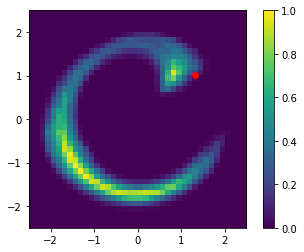

In [10]:
idx = 12
plt.imshow(store[idx][0]['image'], **imkwargs)
plt.scatter(*store[idx][1], c="r")
plt.colorbar()

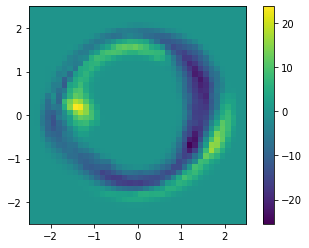

In [11]:
plt.imshow(store[1][0]['image']-store[-1][0]['image'], **imkwargs)
plt.colorbar()

In [12]:
marginals = [i for i in range(40**2)]

In [13]:
dataset = swyft.Dataset(NSIM, prior, store)

In [14]:
img_0 = dataset[0][0]['image']
L1, L2 = tensor(img_0.shape)
assert L1 == L2
L = L1.item()
print(f'L = {L}')

In [15]:
# z = np.zeros((2, 3, 3))
# print(z)
# print()
# # idx = torch.tensor(((0, 1, 1), (1, 2, 2), (0, 0, 2)))
# idx = torch.tensor(((0, 1, 0), (0, 0, 1), (0, 0, 2))).tolist()

# # idx = torch.tensor(( (0,1) )).tolist()

# # idx = (0, 1)


# z[tuple(idx)] = 1
# print(z)

In [16]:
# def coord_uv(coords_u):
    
#     lows_l = torch.full_like(coords_u, lows[0])
#     highs_l = torch.full_like(coords_u, highs[0])
    
#     v = lambda u: (highs_l - lows_l) * u + lows_l
#     coords_v = v(coords_u)
#     return coords_v

# def coord_to_map(XY_u):
    
#     XY = XY_u
    
#     n_batch =  XY.shape[0]
#     n_coords = XY.shape[1]
        
#     binary_map = torch.zeros((n_batch, L,L), device = DEVICE)
    
#     x, y = XY[:,0::2], XY[:,1::2]

#     x_i = torch.floor((x*L).flatten()).type(torch.long) 
#     y_i = torch.floor((y*L).flatten()).type(torch.long) 
#     i   = torch.floor(torch.arange(0, n_batch, 1/n_coords*2).to(DEVICE)).type(torch.long) 
    
#     xx = tuple(torch.stack((i, x_i, y_i)))
#     binary_map[xx] = 1

#     return binary_map

# xy_u = torch.from_numpy(np.random.uniform(0, 1, (3, 20))).to(DEVICE)
# plt_imshow(coord_to_map(xy_u).cpu())

# Train

In [17]:
# def coord_uv(coords_u):
#     v = lambda u: (highs - lows) * u + lows
#     coords_v = v(coords_u)
#     return coords_v

# def coord_to_map(XY_u):
    
#     XY = XY_u
#     XY = coord_uv(XY_u)
    
#     halo = torch.zeros((L,L), device = DEVICE)
    
#     x, y = XY[0::2], XY[1::2]
#     x_i, y_i = torch.floor(torch.stack((x*L, y*L))).type(torch.long)
#     halo[y_i, x_i] = 1

#     return halo, XY

def coord_to_map(XY_u):
    
    XY = XY_u
    
    n_batch =  XY.shape[0]
    n_coords = XY.shape[1]
    
        
        
    binary_map = torch.zeros((n_batch, L,L), device = DEVICE)
    
    x, y = XY[:,0::2], XY[:,1::2]

    x_i = torch.floor((x*L).flatten()).type(torch.long) 
    y_i = torch.floor((y*L).flatten()).type(torch.long) 
#     print(n_batch, n_coords)

    if n_coords != 0:
        i   = torch.floor(torch.arange(0, n_batch, 1/n_coords*2).to(DEVICE)).type(torch.long) 
    
        xx = tuple(torch.stack((i, x_i, y_i)))
        binary_map[xx] = 1

    return binary_map
    

class DoubleConv(swyft.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), # bias = False becaise BatchNorm2d is set
            nn.BatchNorm2d(out_channels), # BatchNorm2d were not known when paper came out
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(swyft.Module):
    def __init__(self, n_features, marginals):
        super().__init__(n_features, marginals) 
#         super(UNET, self).__init__()
        
        self.marginals = marginals
        self.n_features = n_features
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # keep size the same
        
        in_channels=1
        out_channels=2
        features=[64, 128, 256, 512]

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        

    def forward(self, sims, target):
                
        sims = sims.view(-1, L, L)
        z = torch.zeros(*sims.shape, device = DEVICE)                
        z = coord_to_map(target)
        
        
        ############# UNet Start ###
        x = sims
        n_batch = len(x)
        x = x.unsqueeze(1)
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse list

        # the upsampling
        for idx in range(0, len(self.ups), 2): # step of 2 because we want up - double column - up - double column
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2] # //2 because we want still steps of one

            # if statement because we can put in shapes that are not divisble by two around 19:00 of video
            if x.shape != skip_connection.shape: 
                x = TF.resize(x, size=skip_connection.shape[2:]) # hopefully does not impact accuracy too much

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        ############# UNet End ###
        
                
        # L[C]
        x = x[:,0] * (1 - z) + x[:,1] * z 
    
        x = x.view(-1, self.n_features)
        return x

class CustomHead(swyft.Module):

    def __init__(self, obs_shapes) -> None:
        super().__init__(obs_shapes=obs_shapes)
        self.n_features = torch.prod(tensor(obs_shapes['image']))

    def forward(self, obs) -> torch.Tensor:
        x = obs["image"]
        n_batch = len(x)
        x = x.view(n_batch, self.n_features)
        return x

torch.set_default_tensor_type(torch.FloatTensor)
post = swyft.Posteriors(dataset)
post.add(marginals, device = DEVICE, head = CustomHead, tail = UNET)
post.train(marginals, max_epochs = 5, batch_size = 8)

Training: lr=0.001, Epoch=5, VL=2217


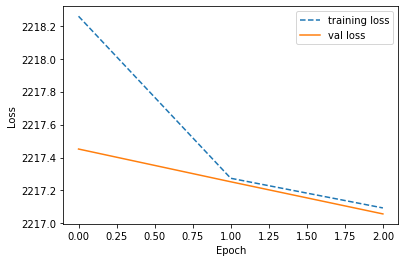

In [18]:
def get_losses():
        
    keys = list(post._ratios.keys())
    assert len(keys) == 1
    losses = post._ratios[keys[0]]._train_diagnostics
    assert len(losses) == 1
    tl = losses[0]['train_loss']
    vl = losses[0]['valid_loss']
    epochs = np.arange(len(tl))
    return epochs, tl, vl

def plot_losses():
    fig, ax = plt.subplots(1, 1)
    
    epochs, tl, vl = get_losses()
    ax.plot(epochs, tl, '--', label = f'training loss')
    ax.plot(epochs, vl, '-', label = f'val loss')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    plt.legend()
    
    
    plt.show()
    
    
        
plot_losses()

In [19]:
net = 'net.pt'
post.save(net)

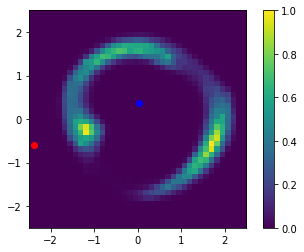

In [29]:
i = np.random.randint(len(dataset))
obs0 = dataset[i][0]
u0 = dataset[i][1]
v0 = dataset[i][2]
u0m = torch.tensor(np.array(np.flipud(u0.numpy())))

# print(obs0)
# print('u', u0)
# print('vu', vu(u0.numpy()))
# print('v', v0)

plt.imshow(obs0['image'].cpu(), **imkwargs)
plt.scatter(*v0.t(), c="r")
plt.scatter(*u0.t(), c="b")
# plt.scatter(*vu(u0.numpy()), c="y")
plt.colorbar()
plt.show()

# plt.imshow(obs0['image'].cpu(), **imkwargs)
# # plt.scatter(*v0.t(), c="r")
# plt.scatter(*u0.t(), c="b")
# plt.scatter(*vu(u0.numpy()), c="y")
# plt.colorbar()
# plt.show()

# Get results

In [30]:
grid = torch.linspace(0,(L-1)/L,L)
x, y = torch.meshgrid(grid, grid, indexing = 'xy')
xy_full = torch.transpose(torch.stack((x.flatten(), y.flatten())), 0, 1).flatten()
xy_empty = tensor(())

In [22]:
# def coord_uv(coords_u):
    
#     lows_l = torch.full_like(coords_u, lows[0])
#     highs_l = torch.full_like(coords_u, highs[0])
    
#     v = lambda u: (highs_l - lows_l) * u + lows_l
#     coords_v = v(coords_u)
#     return coords_v

In [31]:
def ratio(w):
    r = np.zeros((L**2))
    for i, (key, value) in enumerate(w.items()):
        r[i] = value
    return r.T.reshape(L, L)

def get_ratio(obs0, coords):
#     print('hi')
    samples = post.sample(N = 1, obs0 = obs0, n_batch = 1, v = coords.view(1, -1))
    v = samples['v']
    w = samples['weights']
    return ratio(w)


    

p_0 = get_ratio(obs0, xy_empty)/(L*L)
p_1 = get_ratio(obs0, xy_full)/(L*L)


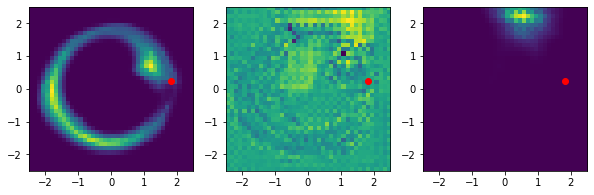

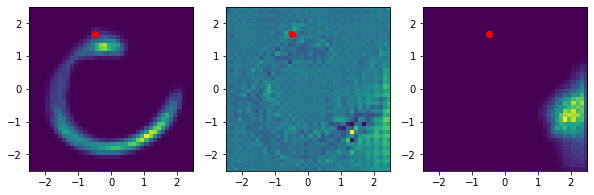

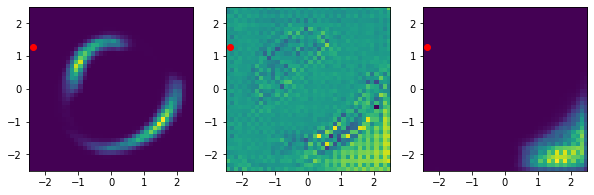

In [37]:
for _ in range(3):
    i = np.random.randint(len(dataset))
    obs0 = dataset[i][0]
    u0 = dataset[i][1]
    v0 = dataset[i][2]

    fig, axs = plt.subplots(1, 3, figsize = (10, 5))
    
    p_0 = get_ratio(obs0, xy_empty)/(L*L)
    p_1 = get_ratio(obs0, xy_full)/(L*L)

    axs[0].imshow(obs0['image'].cpu(), **imkwargs)
    axs[1].imshow(p_0, **imkwargs)
    axs[2].imshow(p_1, **imkwargs)

    for ax in axs:
        ax.scatter(*v0.t(), c="r")

In [25]:
xy_full

tensor([0.0000, 0.0000, 0.0250,  ..., 0.9750, 0.9750, 0.9750])

In [26]:
assert 1 == 2

AssertionError: 

In [ ]:
Npars_sample = 1000
samples = post.sample(Npars_sample, obs0)

In [ ]:
v = samples['v']
w = samples['weights']

In [ ]:
keys = list(w.keys())
v.shape, len(w), w[keys[0]].shape

In [ ]:
L = 40

def get_imgs(v):
    img = np.zeros((Npars_sample, L, L))
    for i in range(Npars_sample):
        img[i] = simul(v[i], CONFIG)['image']
    return img

imgs = get_imgs(v)

In [ ]:
def ratio(w):
    r = np.zeros((L**2, Npars_sample))
    for i, (key, value) in enumerate(w.items()):
        r[i] = value
    return r.T.reshape(Npars_sample, L, L)

        
r = ratio(w)


In [ ]:
N = 5
plots = [imgs[i] for i in range(N)] + [r[i] for i in range(N)]
titles = np.array([[title] + ['']*(N-1) for title in ['imgs = simulator(v)', 'reshaped w (= ratios?)']]).flatten(),
plt_imshow(plots, 2, cbar = True, titles = titles[0], **imkwargs)

In [ ]:
for i in np.random.randint(0, Npars_sample, 4):
    
    
    obs0 = dataset[i][0]
    v0 = dataset[i][2]
    
    samples = post.sample(Npars_sample, obs0)
    

    v = samples['v']
    w = samples['weights'] 
        
    r = ratio(w) 
    
    true = simul(v0, CONFIG)['image']
    
    
    true_map = coord_to_map(obs0['image'].cuda(), v0.cuda(), False)[0]

#     r_plot = np.mean(r, axis = 0)
#     r_plot -= r_plot.min()
#     r_plot /= r_plot.max()

#     fig, axs = plt.subplots(3, 1, figsize = (10, 10), sharex = False)
#     axs[0].plot(np.std(r, axis = 0).flatten())
#     axs[1].plot(r_plot.flatten())
#     axs[2].plot(true.flatten(), label = 'true')

    rmean = np.mean(r, axis = 0)
    
    
    plots = [obs0['image'], rmean, rmean]
    titles = ['obs0', 'mean of ratios (with v0 as cross)', 'mean of ratios (without v0 as cross)']
    
    fig, axs = plt.subplots(1, len(plots)+2, figsize = (20, 5))
    for ax, plot, title in zip(axs, plots, titles):
        im = ax.imshow(plot, **imkwargs, cmap = 'viridis')
        fig.colorbar(im, ax=ax, shrink = 0.5)
        ax.set_title(title, fontsize = 15)
        
    for ax in [axs[0], axs[1]]: 
        for j in range(0, 2*N_SUB, 2):
            ax.scatter(*v0[j:j+2], marker = 'x', c = 'r', s = 100)
            
    axs[-2].plot(rmean.flatten())  
    axs[-2].set_title(f'sum(r) = {np.sum(rmean)}')
    
    axs[-1].plot(true_map.flatten(), color = 'r')
    
    
    plt.show()

### Check posteriors

In [ ]:
# post = swyft.Posteriors.load(net).to(DEVICE)

In [ ]:
# # torch.set_default_tensor_type(torch.FloatTensor)  # HACK
# idx = 10 # choose different observation 
# IMAGE = store[idx][0]["image"]
# v0 = store[idx][1]
# samples = post.sample(100000, {"image": IMAGE})

# swyft.plot_corner(
#     samples, 
#     [0, 1], 
#     color='k', 
#     figsize = (8,8), 
#     truth=v0, 
#     bins = 40);

# torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK